# Notebook initialization

## Selecting best GPU

In [30]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = 0#min(zip(ids, ratios), key=lambda x: x[1])[0]

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

setGPU: Setting GPU to: 0


##  Global variables

In [2]:
# IPython extension to reload modules before executing user code.
# 'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")

simulation_id = 7
weights_id = 6

weights_path = lambda name: '../weights/{}/{}/'.format(weights_id, name)
dw_path = lambda name: 'dw/{}/{}'.format(simulation_id, name)
figures_path = lambda name: 'figures/{}/{}/'.format(simulation_id, name)

## Seed initialization (for reproductible results)

In [3]:
# Setting the seed for NumPy generated random numbers
import numpy as np
np.random.seed(0)

# Setting the seed for Python random numbers
import random as rn
rn.seed(0)

# Setting the seed for TensorFlow random numbers
import tensorflow as tf
tf.set_random_seed(0)

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


# Importing weights

In [4]:
from models import VGG16_beta
import numpy as np
import keras
import matplotlib.pyplot as plt
from collections import defaultdict
from numpy.linalg import norm
import itertools
from keras_utils import get_kernel_layer_names, get_kernel_layer, get_kernel_weights

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
import pathlib
import pickle
import progressbar
import time
import seaborn as sns
from math import floor

In [5]:
num_classes=10

In [6]:
# Simply loading both the initial and finals weights of our models

models = {  
    'vgg16_sgd_0':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_sgd_1':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_sgd_2':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    
    'vgg16_wdecay_0':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    'vgg16_wdecay_1':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    'vgg16_wdecay_2':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    
    'vgg16_layca_0':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_layca_1':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_layca_2':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0)
} 

layer_names = [name.split('_', 1)[0] for name in get_kernel_layer_names(models['vgg16_sgd_0'])]
n_layers = len(get_kernel_layer_names(models['vgg16_sgd_0']))

In [7]:
for name, model in models.items():
    print(name)
    model.load_weights(weights_path(name) + 'initial/weights-initial.hdf5') 

vgg16_layca_1
vgg16_sgd_0
vgg16_layca_2
vgg16_wdecay_1
vgg16_sgd_2
vgg16_wdecay_0
vgg16_wdecay_2
vgg16_layca_0
vgg16_sgd_1


In [8]:
W0 = defaultdict(list)
for name, model in models.items():
    print(name)
    W0[name] =  get_kernel_weights(model)

vgg16_layca_1
vgg16_sgd_0
vgg16_layca_2
vgg16_wdecay_1
vgg16_sgd_2
vgg16_wdecay_0
vgg16_wdecay_2
vgg16_layca_0
vgg16_sgd_1


In [46]:
for name, model in models.items():
    print(name)
    model.load_weights(weights_path(name) + 'final/weights-final.hdf5') 

vgg16_layca_1
vgg16_sgd_0
vgg16_layca_2
vgg16_wdecay_1
vgg16_sgd_2
vgg16_wdecay_0
vgg16_wdecay_2
vgg16_layca_0
vgg16_sgd_1


In [47]:
Wn = defaultdict(list)
for name, model in models.items():
    print(name)
    Wn[name] = get_kernel_weights(model)

vgg16_layca_1
vgg16_sgd_0
vgg16_layca_2
vgg16_wdecay_1
vgg16_sgd_2
vgg16_wdecay_0
vgg16_wdecay_2
vgg16_layca_0
vgg16_sgd_1


In [11]:
pathlib.Path('w').mkdir(parents=True, exist_ok=True)

# Analyse

## Amplitude de la variation de poids $\Delta w^{(l)}$

In [11]:
colors_light = dict(zip(['vgg16_sgd_0', 
                    'vgg16_sgd_1', 
                    'vgg16_sgd_2',
                    'vgg16_wdecay_0', 
                    'vgg16_wdecay_1', 
                    'vgg16_wdecay_2', 
                    'vgg16_layca_0', 
                    'vgg16_layca_1', 
                    'vgg16_layca_2'],
                  
                  ['#FF4940',
                   '#FF0D00',
                   '#A60800',
                   '#52E9A3',
                   '#1DD300',
                   '#138900',
                   '#66A3D2',
                   '#3F92D2',
                   '#0B61A4']))  


colors = dict(zip(['vgg16_sgd_0', 
                    'vgg16_sgd_1', 
                    'vgg16_sgd_2',
                    'vgg16_wdecay_0', 
                    'vgg16_wdecay_1', 
                    'vgg16_wdecay_2', 
                    'vgg16_layca_0', 
                    'vgg16_layca_1', 
                    'vgg16_layca_2'],
                  
                  ['#A60800',
                   '#138900',
                   '#0B61A4',
                   '#A60800',
                   '#138900',
                   '#0B61A4',
                   '#A60800',
                   '#138900',
                   '#0B61A4']))  

### SGD

In [ ]:
model_name = 'vgg16_sgd_0'

for layer in range(n_layers):
    w0 = W0[model_name][layer].flatten()
    wn = Wn[model_name][layer].flatten()
    
    dw = wn - w0
    
    fig, ax = plt.subplots()

    #ax.hist(dw, bins=100, color=colors[model_name], histtype = 'step')
    
    ax = sns.distplot(dw, hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = model_name)
    
    ax.legend(loc='best')
    ax.set_xlabel(r'$|\Delta w^{(l)}|$')
    ax.set_ylabel('Occurrence')
    ax.set_title('Distribution of $\Delta w^{(l)}$')
        
    
    
    plt.show()

### weight decay

In [ ]:
model_name = 'vgg16_layca_0'

for layer in range(n_layers):
    w0 = W0[model_name][layer].flatten()
    wn = Wn[model_name][layer].flatten()
    
    dw = wn - w0
    
    fig, ax = plt.subplots()

    #ax.hist(dw, bins=100, color=colors[model_name], histtype = 'step')
    
    ax = sns.distplot(dw, hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = model_name)
    
    ax.legend(loc='best')
    ax.set_xlabel(r'$|\Delta w^{(l)}|$')
    ax.set_ylabel('Occurrence')
    ax.set_title('Distribution of $\Delta w^{(l)}$')
        
    
    
    plt.show()

### layca

In [ ]:
for layer in range(n_layers):
    fig, ax = plt.subplots()
    
    for model_name, style in zip(['vgg16_layca_0', 'vgg16_layca_1', 'vgg16_layca_2'],
                                 [':', '--', '-']):
                                 
        w0 = W0[model_name][layer].flatten()
        wn = Wn[model_name][layer].flatten()
        dw = wn - w0
    
        sns.distplot(dw, hist = False, kde = True,
                     kde_kws = {'linewidth': 2, 'linestyle': style},
                     ax = ax,
                     label = model_name)
    
    ax.legend(loc='best')
    ax.set_xlabel(r'$|\Delta w^{(l)}|$')
    ax.set_ylabel('Density')
    ax.set_title('Distribution of $\Delta w^{(l)}$')
    
    
    plt.show()

### mixte

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2


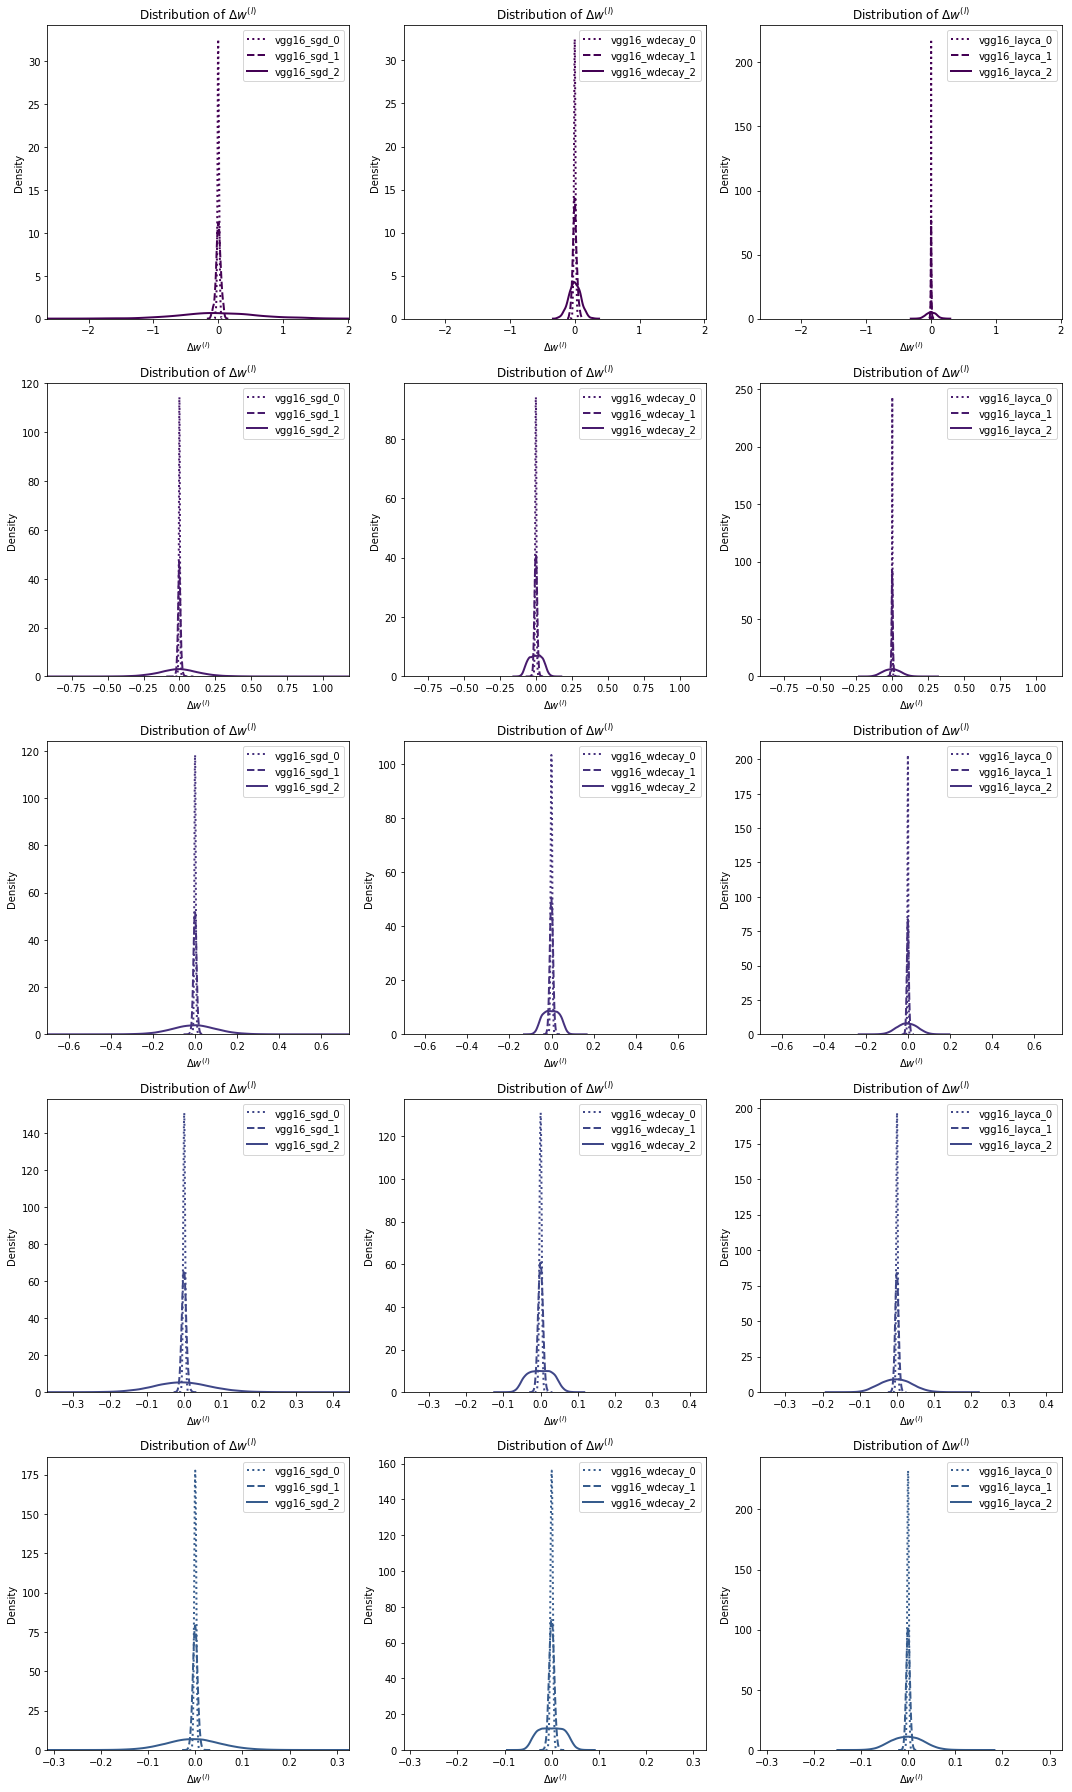

In [15]:
cm = plt.get_cmap('viridis')
cm_inputs = np.linspace(0, 1, n_layers)
colors = [cm(i) for i in cm_inputs]

fig, axes = plt.subplots(5, 3, figsize=(15,25))

layers = range(0, 5)

heights = [150, 150, 200, 300, 300]

for i, layer, color in zip(range(len(layers)), layers, colors[layers[0]:layers[-1]+1]):
    
    min_axis = 0
    max_axis = 0
    
    for j, model_abrv in enumerate(['sgd', 'wdecay', 'layca']):
        
        print(i,j)
        
        for model_name, style in zip(['vgg16_'+model_abrv+'_0', 
                                      'vgg16_'+model_abrv+'_1', 
                                      'vgg16_'+model_abrv+'_2'], 
                                     [':', '--', '-']):
            w0 = W0[model_name][layer].flatten()
            wn = Wn[model_name][layer].flatten()
            dw = wn - w0
            
            min_axis = min(min_axis, min(dw))
            max_axis = max(max_axis, max(dw))
            
            sns.distplot(dw, hist = False, kde = True,
                              kde_kws = {'linewidth': 2,'linestyle': style},                          
                              color=color,
                              ax=axes[i, j],
                              label = model_name)


        axes[i, j].legend(loc='best')
        axes[i, j].set_xlabel(r'$\Delta w^{(l)}$')
        axes[i, j].set_ylabel('Density')
        axes[i, j].set_title('Distribution of $\Delta w^{(l)}$')
    
    for j in range(3):
        axes[i, j].set_xlim(min_axis, max_axis)
        #axes[i, j].set_ylim(0, heights[i])
        
fig.tight_layout()
plt.show()

In [127]:
fig.savefig('dw/multi_dw_2.png', dpi=100)

## Amplitude de la variation de poids normalisée $\dfrac{\Delta w^{(l)}}{||w^{(l)}_n||}$

### mixte

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2


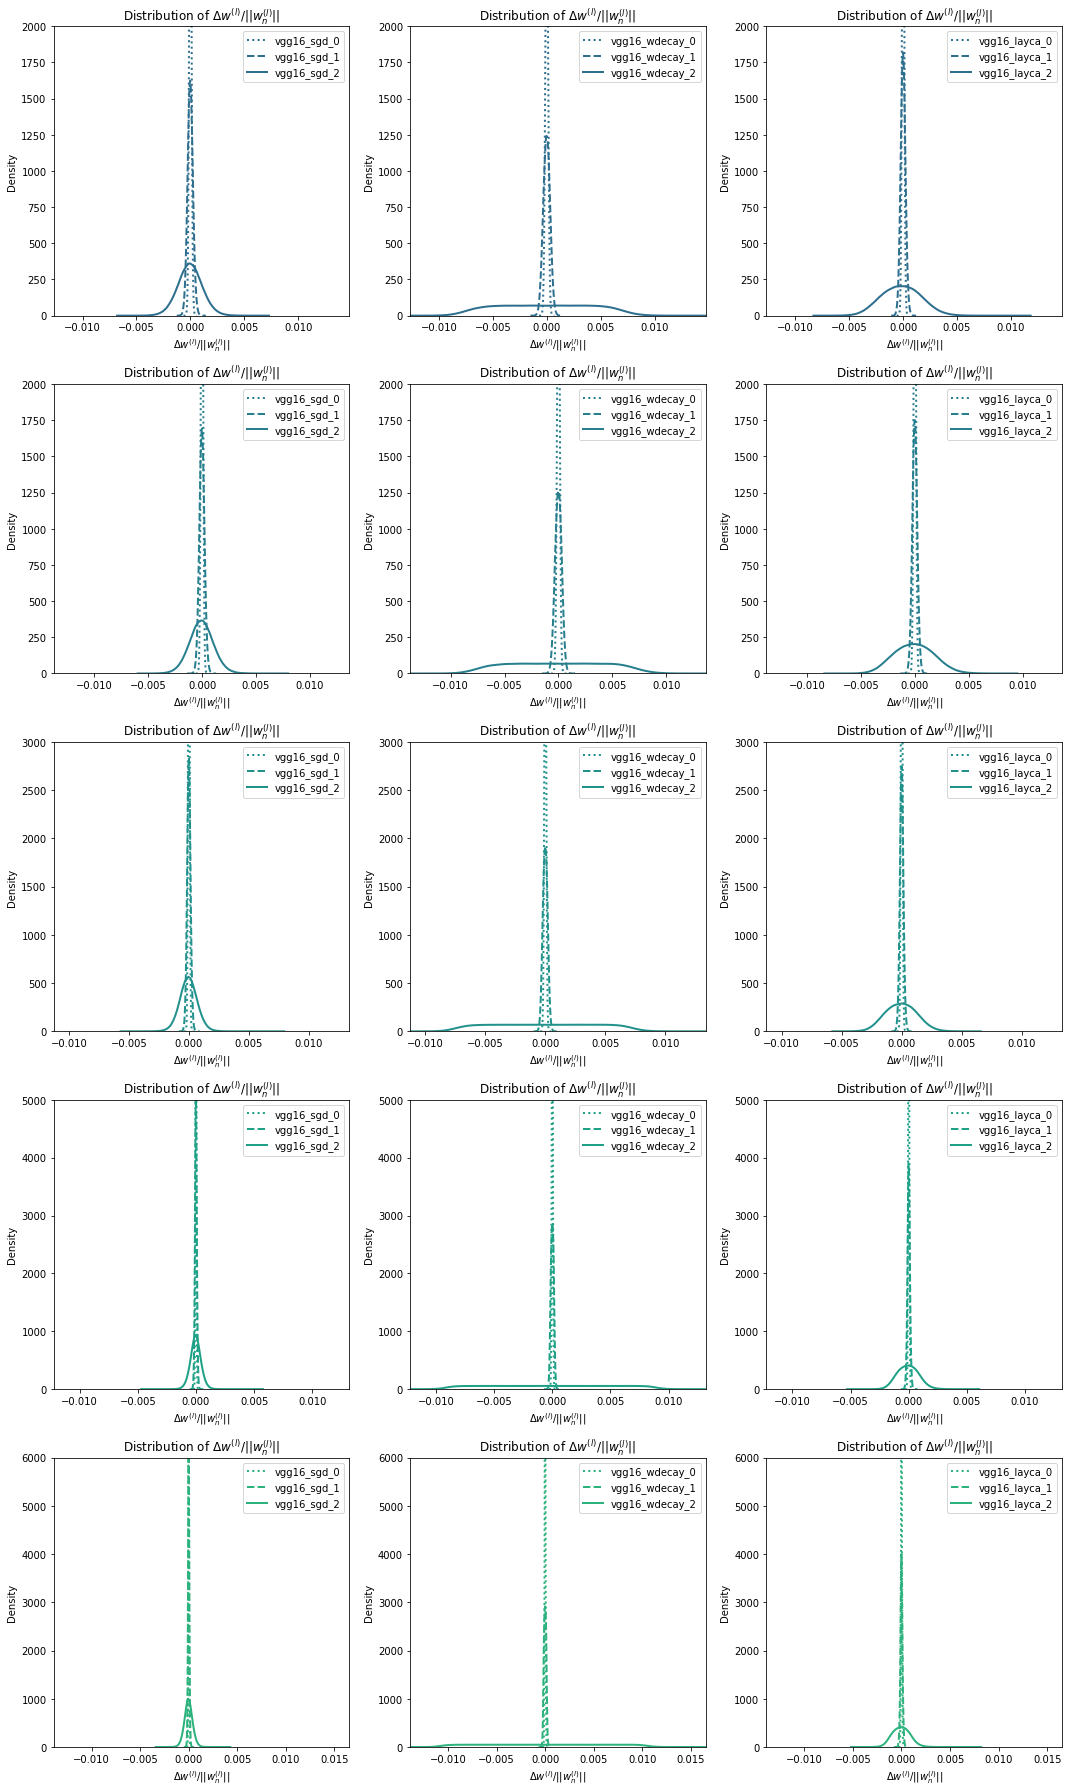

In [143]:
cm = plt.get_cmap('viridis')
cm_inputs = np.linspace(0, 1, n_layers)
colors = [cm(i) for i in cm_inputs]

fig, axes = plt.subplots(5, 3, figsize=(15,25))

layers = range(5, 10)
heights = [2000, 2000, 3000, 5000, 6000]

for i, layer, color in zip(range(len(layers)), layers, colors[layers[0]:layers[-1]+1]):
    
    min_axis = 0
    max_axis = 0
    
    for j, model_abrv in enumerate(['sgd', 'wdecay', 'layca']):
        
        print(i,j)
        
        for model_name, style in zip(['vgg16_'+model_abrv+'_0', 
                                      'vgg16_'+model_abrv+'_1', 
                                      'vgg16_'+model_abrv+'_2'], 
                                     [':', '--', '-']):
            w0 = W0[model_name][layer].flatten()
            wn = Wn[model_name][layer].flatten()
            dw = (wn - w0)/np.linalg.norm(wn)
            
            min_axis = min(min_axis, min(dw))
            max_axis = max(max_axis, max(dw))
            
            sns.distplot(dw, hist = False, kde = True,
                              kde_kws = {'linewidth': 2,'linestyle': style},                          
                              color=color,
                              ax=axes[i, j],
                              label = model_name)



        axes[i, j].legend(loc='best')
        axes[i, j].set_xlabel(r'$\Delta w^{(l)}/||w^{(l)}_n||$')
        axes[i, j].set_ylabel('Density')
        axes[i, j].set_title('Distribution of $\Delta w^{(l)}/||w^{(l)}_n||$')
    
    for j in range(3):
        axes[i, j].set_xlim(min_axis, max_axis)
        axes[i, j].set_ylim(0, heights[i])
        
fig.tight_layout()
plt.show()

In [144]:
fig.savefig('dw/multi_dw_norm_2.png', dpi=100)

## Cosinus distance relooké

vgg16_sgd_0
vgg16_wdecay_0
vgg16_layca_0
vgg16_sgd_1
vgg16_wdecay_1
vgg16_layca_1
vgg16_sgd_2
vgg16_wdecay_2
vgg16_layca_2


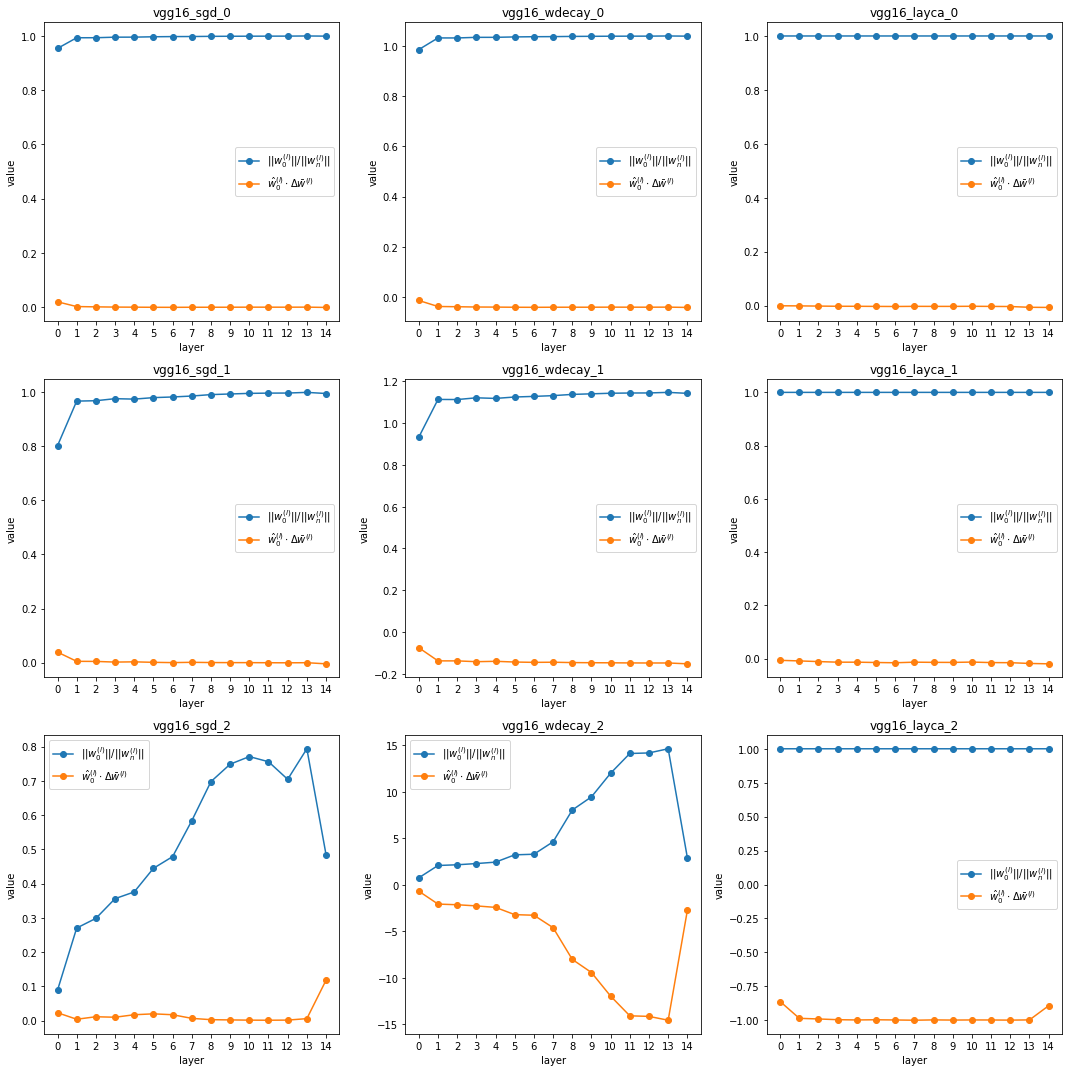

In [24]:
cm = plt.get_cmap('viridis')
cm_inputs = np.linspace(0, 1, n_layers)
colors = [cm(i) for i in cm_inputs]

fig, axes = plt.subplots(3, 3, figsize=(15,15))

term1 = defaultdict(list)
term2 = defaultdict(list)

for i in range(3):
    for j, model_abrv in enumerate(['sgd', 'wdecay', 'layca']):
        
        model_name = 'vgg16_' + model_abrv + '_{}'.format(i)
        print(model_name)
        
        for layer in range(n_layers):
        
            w0 = W0[model_name][layer].flatten()
            wn = Wn[model_name][layer].flatten()

            w0_hat = w0/np.linalg.norm(w0)
            dw_hat = (wn - w0)/np.linalg.norm(wn)
            
            term1[model_name].append(np.linalg.norm(w0)/np.linalg.norm(wn))
            term2[model_name].append(np.dot(w0_hat, dw_hat))
        
        
        axes[i,j].plot(range(n_layers), term1[model_name], linestyle='-', marker='o', label=r'$||w^{(l)}_0||/||w^{(l)}_n||$')
        axes[i,j].plot(range(n_layers), term2[model_name], linestyle='-', marker='o', label=r'$\hat{w}^{(l)}_0 \cdot \Delta \bar{w}^{(l)}$')
        
        axes[i,j].set_title(model_name)
        axes[i,j].set_ylabel('value')
        axes[i,j].set_xlabel('layer')
        axes[i,j].set_xticks(range(0, n_layers))
        axes[i,j].legend(loc='best')
        
fig.tight_layout()
plt.show()

In [25]:
fig.savefig('dw/multi_terms.png', dpi=100)

## Outliers

In [55]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [64]:

# for i in range(3):
#     for j, model_abrv in enumerate(['sgd', 'wdecay', 'layca']):
        
# model_name = 'vgg16_' + model_abrv + '_{}'.format(i)
# print(model_name)

model_name = 'vgg16_layca_2'

for layer in range(n_layers):

    w0 = W0[model_name][layer].flatten()
    wn = Wn[model_name][layer].flatten()

    dw = (wn - w0)
    w0_hat = w0/np.linalg.norm(w0)
    dw_bar = dw/np.linalg.norm(wn)

    product = w0_hat * dw_bar

    upper_quartile = np.percentile(dw, 75)
    lower_quartile = np.percentile(dw, 25)
    IQR = (upper_quartile - lower_quartile) * 1
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)

    outliers = product[outliers_iqr(dw_bar)]
        
    positive_outliers = [x for x in outliers if x >=0]
    negative_outliers = [x for x in outliers if x < 0]

    prop_positive_outliers = len(positive_outliers)/len(product)
    prop_negative_outliers = len(negative_outliers)/len(product)       

    prop_positive_sum = np.sum(positive_outliers)/np.sum(product[np.where(product >= 0)])
    prop_negative_sum = np.sum(negative_outliers)/np.sum(product[np.where(product < 0)])

    print('{:.2f} {:.2f} {:.2f} {:.2f}'.format(prop_positive_outliers*100, 
                               prop_negative_outliers*100,
                               prop_positive_sum*100,
                               prop_negative_sum*100))
        


0.00 0.41 0.00 2.29
0.01 0.27 0.28 1.38
0.01 0.33 0.12 1.82
0.00 0.35 0.12 1.89
0.01 0.39 0.16 2.09
0.01 0.39 0.25 2.10
0.01 0.35 0.21 1.89
0.01 0.37 0.14 2.03
0.02 0.47 0.46 2.51
0.04 0.58 1.55 3.04
0.05 0.80 1.67 4.12
0.10 0.91 3.45 4.57
0.12 1.19 4.03 5.94
0.01 0.44 0.17 2.18
0.00 0.27 0.00 1.57


In [61]:

# for i in range(3):
#     for j, model_abrv in enumerate(['sgd', 'wdecay', 'layca']):
        
# model_name = 'vgg16_' + model_abrv + '_{}'.format(i)
# print(model_name)

model_name = 'vgg16_layca_2'

for layer in range(n_layers):

    w0 = W0[model_name][layer].flatten()
    wn = Wn[model_name][layer].flatten()

    upper_quartile = np.percentile(wn, 75)
    lower_quartile = np.percentile(wn, 25)
    IQR = (upper_quartile - lower_quartile) * 1
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)

    outliers = wn[outliers_iqr(wn)]       

    prop_outliers = len(outliers)/len(wn)

    prop_norm = np.linalg.norm(outliers)/np.linalg.norm(wn)

    print('{:.2f} {:.2f}'.format(prop_outliers*100, 
                               prop_norm*100))
        


1.79 38.99
0.93 29.62
1.22 33.91
1.21 33.39
1.46 36.46
1.48 36.33
1.31 34.68
1.43 36.08
2.10 42.82
2.69 49.91
5.87 66.55
8.23 74.45
14.45 87.96
1.73 36.74
6.15 64.28


In [66]:

# for i in range(3):
#     for j, model_abrv in enumerate(['sgd', 'wdecay', 'layca']):
        
# model_name = 'vgg16_' + model_abrv + '_{}'.format(i)
# print(model_name)

model_name = 'vgg16_wdecay_2'

for layer in range(n_layers):

    w0 = W0[model_name][layer].flatten()
    wn = Wn[model_name][layer].flatten()

    dw = (wn - w0)
    w0_hat = w0/np.linalg.norm(w0)
    dw_bar = dw/np.linalg.norm(wn)

    product = w0_hat * dw_bar
       
    positive = [x for x in product if x >=0]
    negative = [x for x in product if x < 0]

    prop_positive = len(positive)/len(product)
    prop_negative = len(negative)/len(product)       

    prop_positive_sum = np.sum(positive)/np.sum(product[np.where(product >= 0)])
    prop_negative_sum = np.sum(negative)/np.sum(product[np.where(product < 0)])

    print('{:.2f} {:.2f} {:.2f} {:.2f}'.format(prop_positive*100, 
                               prop_negative*100,
                               prop_positive_sum*100,
                               prop_negative_sum*100))
        


27.43 72.57 100.00 100.00
10.72 89.28 100.00 100.00
10.50 89.50 100.00 100.00
10.04 89.96 100.00 100.00
9.34 90.66 100.00 100.00
7.02 92.98 100.00 100.00
6.91 93.09 100.00 100.00
4.83 95.17 100.00 100.00
2.77 97.23 100.00 100.00
2.34 97.66 100.00 100.00
1.68 98.32 100.00 100.00
1.32 98.68 100.00 100.00
1.21 98.79 100.00 100.00
1.60 98.40 100.00 100.00
7.30 92.70 100.00 100.00


# Poids favorisés

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2


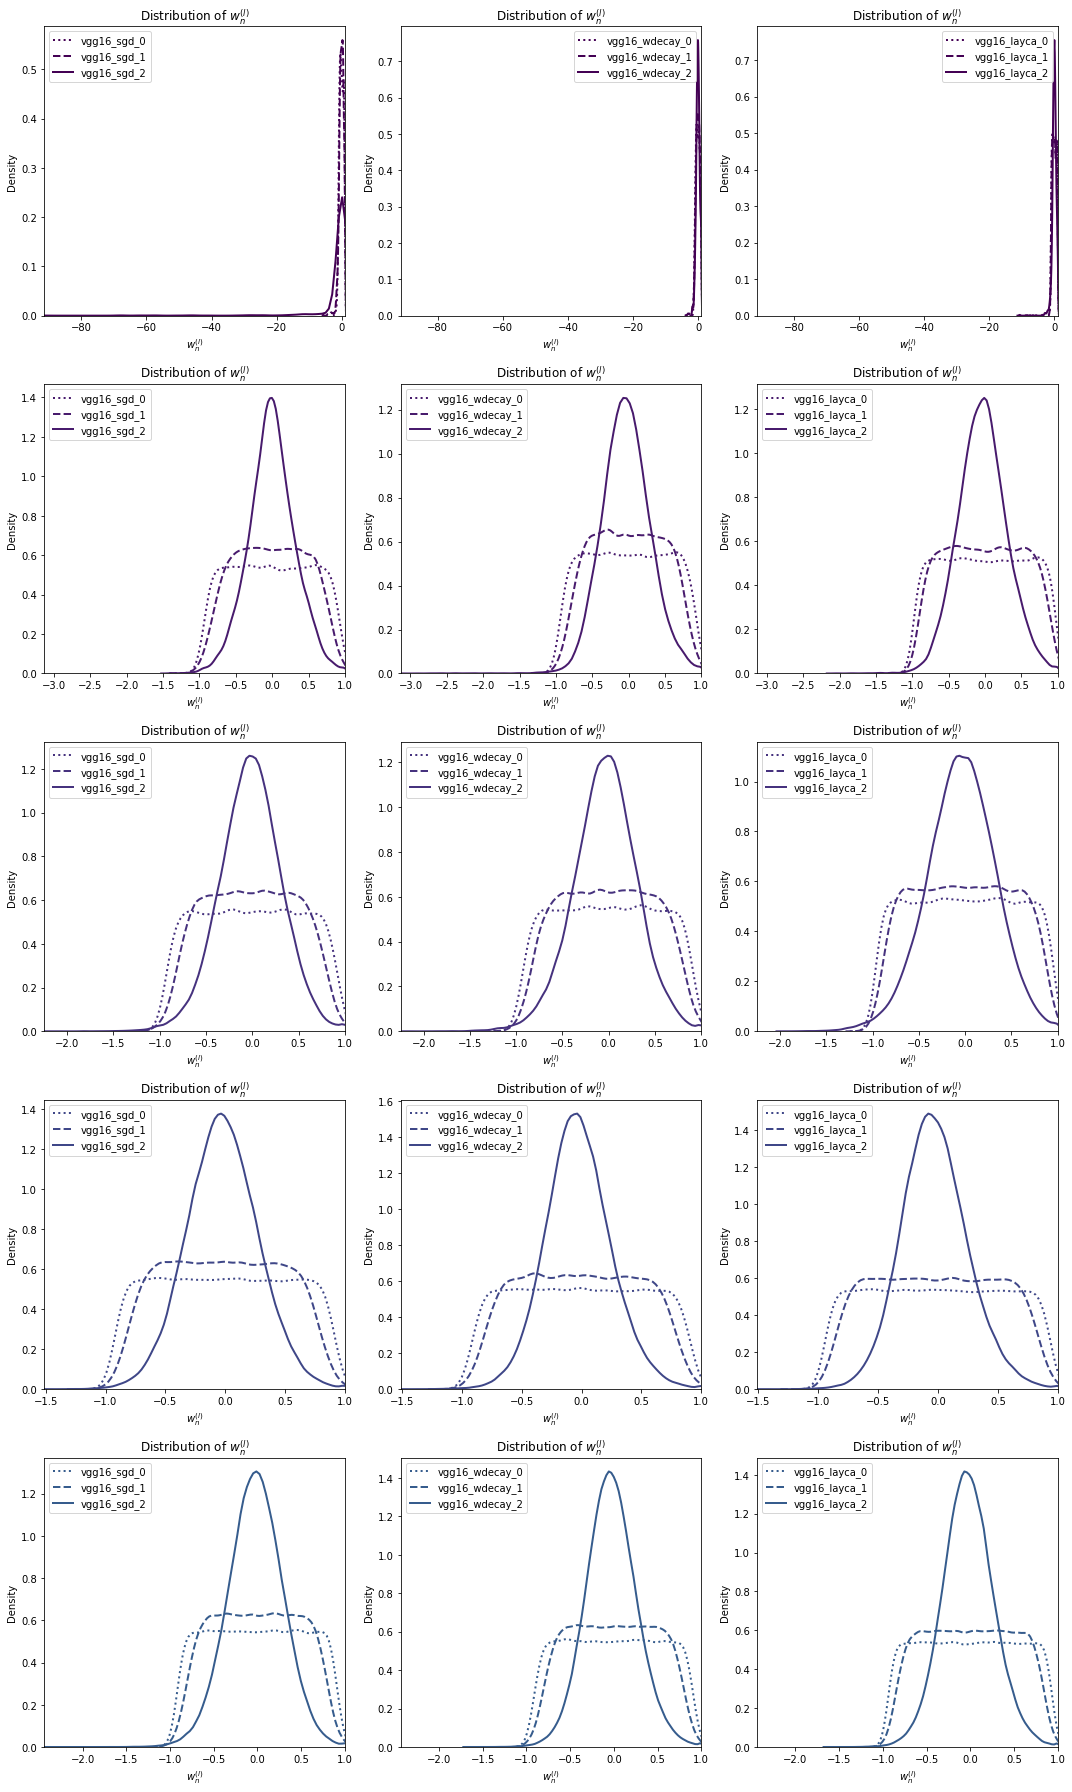

In [64]:
cm = plt.get_cmap('viridis')
cm_inputs = np.linspace(0, 1, n_layers)
colors = [cm(i) for i in cm_inputs]

fig, axes = plt.subplots(5, 3, figsize=(15,25))

layers = range(0, 5)
heights = [2000, 2000, 3000, 5000, 6000]

for i, layer, color in zip(range(len(layers)), layers, colors[layers[0]:layers[-1]+1]):
    
    min_axis = 0
    max_axis = 0
    
    for j, model_abrv in enumerate(['sgd', 'wdecay', 'layca']):
        
        print(i,j)
        
        for model_name, style in zip(['vgg16_'+model_abrv+'_0', 
                                      'vgg16_'+model_abrv+'_1', 
                                      'vgg16_'+model_abrv+'_2'], 
                                     [':', '--', '-']):

#         for model_name, style in zip(['vgg16_'+model_abrv+'_2'], 
#                                      ['-']):
            
#             w0 = W0[model_name][layer].flatten()
            wn = Wn[model_name][layer]
#             wn_norm = np.linalg.norm(wn, axis=-1, keepdims=True)
            
#             norms = np.zeros((wn.shape[-1],1))
            
#             for channel in range(wn.shape[-1]):
#                 if wn.ndim == 4:
#                     norms[channel] = np.linalg.norm(wn[:,:,:,channel])
#                 else:
#                     norms[channel] = np.linalg.norm(wn[:,channel])
                    
                    
            for channel in range(wn.shape[-1]):
                if wn.ndim == 4:
                    wn[:,:,:,channel] /= np.max(wn[:,:,:,channel])
                else:
                    wn[:,channel] /= np.max(wn[:,channel])
    
    
#             wn_max = np.max(np.abs(wn), axis=tuple(range(wn.ndim-1)), keepdims=True) 
            
#             wn = wn / wn_max
            
#             print(wn.shape)
    
            
        
#             quartile_1, quartile_3 = np.percentile(wn, [25, 75])
#             iqr = quartile_3 - quartile_1
#             lower_bound = quartile_1 - (iqr * 1.5)
#             upper_bound = quartile_3 + (iqr * 1.5)

#             wn_pruned = wn[np.where((wn < quartile_1) | (wn > quartile_3))]
            
            min_axis = min(min_axis, np.min(wn))
            max_axis = max(max_axis, np.max(wn))
            
#             axes[i, j].axvline(x=lower_bound, linestyle='--')
#             axes[i, j].axvline(x=upper_bound, linestyle='--')
         
            sns.distplot(wn.flatten(), hist = False, kde = True,
                              kde_kws = {'linewidth': 2,'linestyle': style},                          
                              color=color,
                              ax=axes[i, j],
                              label = model_name)



        axes[i, j].legend(loc='best')
        axes[i, j].set_xlabel(r'$w^{(l)}_n$')
        axes[i, j].set_ylabel('Density')
        axes[i, j].set_title('Distribution of $w^{(l)}_n$')
    
    for j in range(3):
        axes[i, j].set_xlim(min_axis, max_axis)
#         axes[i, j].set_ylim(0, heights[i])
        
fig.tight_layout()
plt.show()

In [65]:
fig.savefig('w/multi_w_1_normalized.png', dpi=100)

# Other experiments

In [8]:
def get_initial_final_weights(name, layer):
    model = models[name]
    
    model.load_weights(weights_path(name) + 'initial/weights-initial.hdf5') 
    W_i = get_kernel_weights(model)[layer].flatten()
    model.load_weights(weights_path(name) + 'final/weights-final.hdf5') 
    W_f = get_kernel_weights(model)[layer].flatten()
    
    return W_i, W_f

In [9]:
def get_epoch_weights(model, epoch, layer):
    model.load_weights(weights_path(name) + 'byepoch/weights-{:02d}.hdf5'.format(epoch)) 
    return get_kernel_weights(model)[layer].flatten()

In [48]:
def compute_difference(W, W_i, W_f):  
    return np.abs(W - W_i) / np.linalg.norm(W_f)

In [11]:
def plot_difference(model_name, layer):
    handle = open('{}/history.pickle'.format(weights_path(model_name)), 'rb')
    history = pickle.load(handle)
    n_epoch = len(history['acc'])
    
    W_i, W_f = get_initial_final_weights(model, layer)
    
    fig, axes = plt.subplots(nrows=n_epoch, ncols=1, figsize=(15, 30))
    
    bar = progressbar.ProgressBar(maxval=n_epoch, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for epoch, ax in enumerate(axes):
        W = get_epoch_weights(model, epoch+1, layer)
        dW = compute_difference(W, W_i, W_f)
        ax.hist(dW, bins='auto')
        
        bar.update(epoch)
        
    fig.tight_layout()

In [12]:
def compare_final(W_i, W_f):#model_name, layer):    
#     W_i, W_f = get_initial_final_weights(model_name, layer)
    
    dW = compute_difference(W_f, W_i, W_f)
    
    signs = np.sign(W_i * W_f)
    
#     bins = np.linspace(0, max(np.max(dW1), np.max(dW2), np.max(dW3)), 100)
    
    return signs, dW
    


In [22]:
with open('{}cosines.pickle'.format(weights_path('vgg16_sgd_2')), 'rb') as handle:
    cosine = pickle.load(handle)
    
print(list(zip(np.arange(len(cosine[-1])), cosine[-1])))

[(0, 0.8882360234856606), (1, 0.7256588935852051), (2, 0.6901594698429108), (3, 0.6340128779411316), (4, 0.6070399880409241), (5, 0.5355206727981567), (6, 0.5039914548397064), (7, 0.4098637104034424), (8, 0.29941678047180176), (9, 0.24925512075424194), (10, 0.22769105434417725), (11, 0.24294662475585938), (12, 0.2939367890357971), (13, 0.2005099058151245), (14, 0.3973986506462097)]


In [23]:
with open('{}cosines.pickle'.format(weights_path('vgg16_wdecay_2')), 'rb') as handle:
    cosine = pickle.load(handle)
    
print(list(zip(np.arange(len(cosine[-1])), cosine[-1])))

[(0, 0.9267788156867027), (1, 0.9903173092752695), (2, 0.9851622190326452), (3, 0.979076137766242), (4, 0.984774804674089), (5, 0.980134466663003), (6, 0.9784937184303999), (7, 0.9789524096995592), (8, 0.9728024527430534), (9, 0.9689783006906509), (10, 0.9658987633883953), (11, 0.961491797119379), (12, 0.962770689278841), (13, 0.9284686371684074), (14, 0.8327789008617401)]


In [24]:
with open('{}cosines.pickle'.format(weights_path('vgg16_layca_2')), 'rb') as handle:
    cosine = pickle.load(handle)
    
print(list(zip(np.arange(len(cosine[-1])), cosine[-1])))

[(0, 0.8619557023048401), (1, 0.9857603330165148), (2, 0.9905513217672706), (3, 0.9958969759754837), (4, 0.9978173370473087), (5, 0.9964304971508682), (6, 0.9979373260866851), (7, 0.9998369624227053), (8, 0.9973885756917298), (9, 0.9986555505311117), (10, 0.9977590488269925), (11, 0.9980746773071587), (12, 0.9990421265829355), (13, 0.9974161298014224), (14, 0.892980732023716)]


In [25]:
def outlier_proportion(x):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile)  
    
    return IQR

In [26]:
def outlier_proportion(x):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * 1.5  
    outliers = a[np.where(a >= upper_quartile + IQR)]
    
    return len(outliers)/len(a)

In [121]:
names = ['vgg16_sgd_2', 'vgg16_wdecay_2', 'vgg16_layca_2']
layers = [5,5,5]
dW = list()

for name, layer in zip(names, layers):
    W_i, W_f = get_initial_final_weights(name, layer)
    signs, dw = compare_final(W_i, W_f)
    print(np.sum(np.array(signs) < 0)/signs.size)
    dW.append(dw)

0.3250172932942708
0.4936370849609375
0.4982503255208333


In [122]:
[outlier_proportion(x) for x in dW]

[0.022221883138020832, 0.0002475314670138889, 0.012371487087673612]

<IPython.core.display.Javascript object>


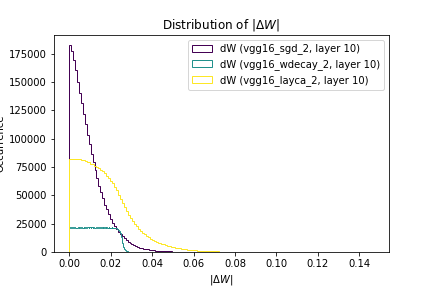

In [50]:
from matplotlib import cm

cm = cm.get_cmap('viridis', 3)
cm_inputs = np.linspace(0, 1, 3)

fig, ax = plt.subplots()

for dw, cm_input, label, layer in zip(dW, cm_inputs, names, layers):
    ax.hist(dw, bins=150, alpha=1, label='dW ({}, layer {})'.format(label, layer), color=cm(cm_input), histtype = 'step')

ax.legend(loc='upper right')
ax.set_xlabel(r'$|\Delta W|$')
ax.set_ylabel('Occurrence')
ax.set_title('Distribution of $|\Delta W|$')
plt.show()

fig.savefig('multi_dw.png', dpi=100)

<IPython.core.display.Javascript object>


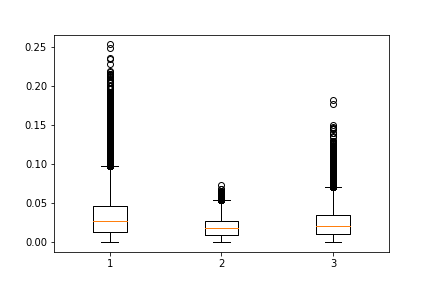

In [123]:
cm = cm.get_cmap('viridis', 3)
cm_inputs = np.linspace(0, 1, 3)

fig, ax = plt.subplots()

# for dw, cm_input, label, layer in zip(dW, cm_inputs, names, layers):
#     ax.hist(dw, bins=150, alpha=1, label='dW ({}, layer {})'.format(label, layer+1), color=cm(cm_input), histtype = 'step')
    
ax.boxplot(dW)

# ax.legend(loc='upper right')
# ax.set_xlabel(r'$|\Delta W|$')
# ax.set_ylabel('Occurrence')
# ax.set_title('Distribution of $|\Delta W|$')
plt.show()

fig.savefig('multi_dw_box.png', dpi=100)

In [59]:
names = ['vgg16_sgd_2', 'vgg16_wdecay_2', 'vgg16_layca_2']
layers = np.arange(15)
dW1 = list()
dW2 = list()
dW3 = list()

term1 = defaultdict(list)
term2 = defaultdict(list)

for dW, name in zip([dW1, dW2, dW3], names):
    print(name)
    model.load_weights(weights_path(name) + 'initial/weights-initial.hdf5') 
    W_i = get_kernel_weights(model)
    model.load_weights(weights_path(name) + 'final/weights-final.hdf5') 
    W_f = get_kernel_weights(model)
    for layer in layers:
        w_i = W_i[layer].flatten()
        w_f = W_f[layer].flatten()
        
        dw = (w_f-w_i)
        dW.append(dw/np.linalg.norm(w_f))
        
        term1[name].append(np.linalg.norm(w_i)/np.linalg.norm(w_f))
        term2[name].append(np.dot(w_i/np.linalg.norm(w_i), dw/np.linalg.norm(w_f)))     
        
#         print(np.sum(np.array(signs) < 0)/signs.size)
        

vgg16_sgd_2
vgg16_wdecay_2
vgg16_layca_2


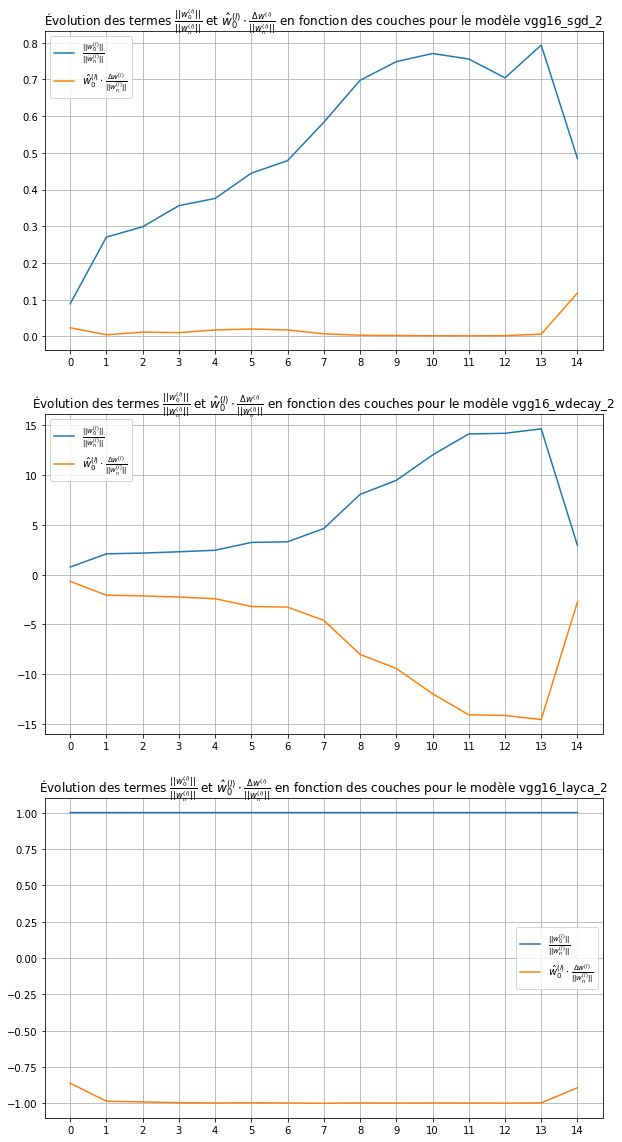

In [68]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 20))

for ax, name in zip(axes, names):
    ax.plot(layers, term1[name], label=r'$\frac{||w^{(l)}_0||}{||w^{(l)}_n||}$')
    ax.plot(layers, term2[name], label=r'$\hat{w}^{(l)}_0 \cdot \frac{\Delta w^{(l)}}{||w^{(l)}_n||}$')
    ax.grid()
    ax.set_xticks(range(0, len(layers)))
    ax.legend(loc='best')
    ax.set_title('Évolution des termes '+ r'$\frac{||w^{(l)}_0||}{||w^{(l)}_n||}$' + ' et ' + r'$\hat{w}^{(l)}_0 \cdot \frac{\Delta w^{(l)}}{||w^{(l)}_n||}$' + ' en fonction des couches pour le modèle ' + name)

plt.show()

fig.savefig('terms.png', dpi=100)

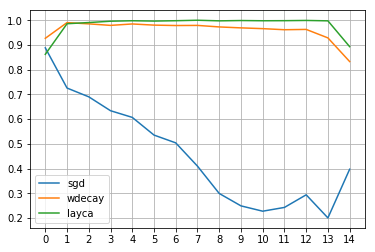

In [32]:
fig, ax = plt.subplots()

with open('{}cosines.pickle'.format(weights_path('vgg16_sgd_2')), 'rb') as handle:
    cosine = pickle.load(handle)
    ax.plot(layers, cosine[-1], label='sgd')
    
with open('{}cosines.pickle'.format(weights_path('vgg16_wdecay_2')), 'rb') as handle:
    cosine = pickle.load(handle)
    ax.plot(layers, cosine[-1], label='wdecay')
    
with open('{}cosines.pickle'.format(weights_path('vgg16_layca_2')), 'rb') as handle:
    cosine = pickle.load(handle)
    ax.plot(layers, cosine[-1], label='layca')

ax.grid()
ax.set_xticks(range(0, len(layers)))
ax.legend(loc='best')
plt.show()

fig.savefig('cosines_multi.png', dpi=100)

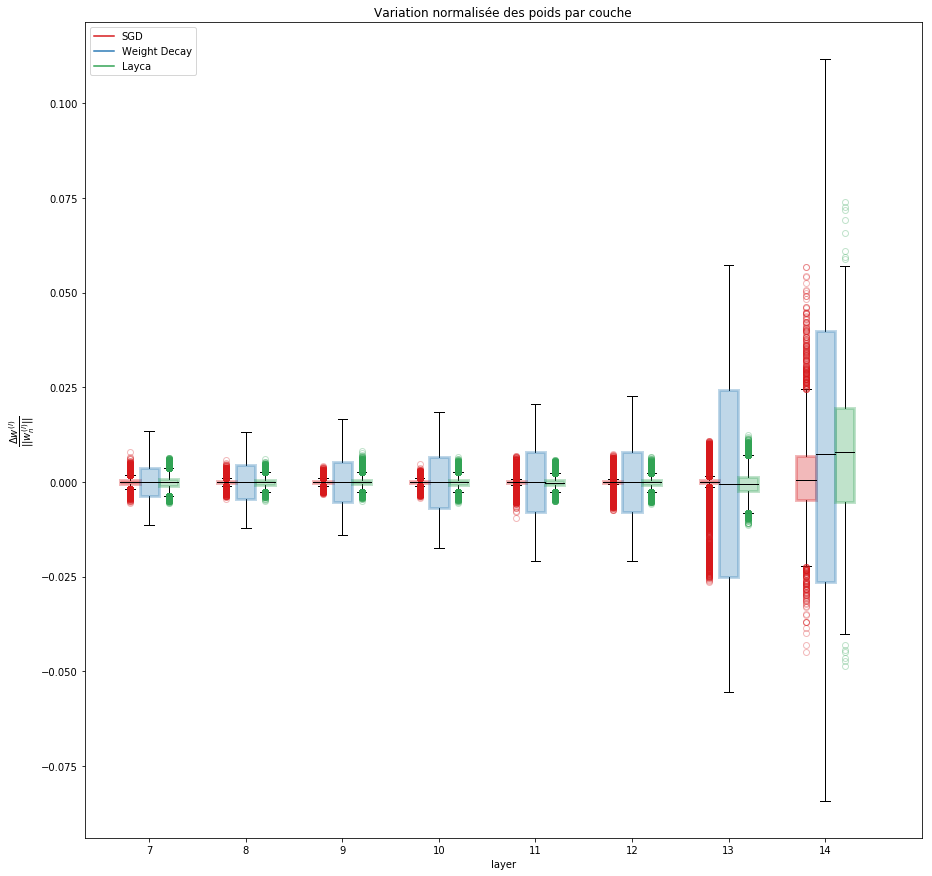

In [64]:
from matplotlib import cm

lo=7
up=15


def set_box_color(ax, bp, color):
#     for element in ['boxes', 'whiskers', 'fliers', 'caps']:
#         plt.setp(bp[element], color='#000000')

    plt.setp(bp['fliers'], markeredgecolor=color, alpha=0.3)
    plt.setp(bp['medians'], color='#000000')
    plt.setp(bp['boxes'], color='#000000', linewidth=3)
    
    for patch in bp['boxes']:
        patch.set(color=color, alpha=0.3)       
    
colors = ['#D7191C', '#2C7BB6', '#31a354'] 
    
fig, ax = plt.subplots(figsize=(15, 15))

bp1 = plt.boxplot(dW1[lo:up], positions=np.arange(len(dW1[lo:up]))*3.0-0.6, widths=0.6, patch_artist=True)
bp2 = plt.boxplot(dW2[lo:up], positions=np.arange(len(dW2[lo:up]))*3.0 ,    widths=0.6, patch_artist=True)
bp3 = plt.boxplot(dW3[lo:up], positions=np.arange(len(dW3[lo:up]))*3.0+0.6, widths=0.6, patch_artist=True)
set_box_color(ax, bp1, colors[0]) # colors are from http://colorbrewer2.org/
set_box_color(ax, bp2, colors[1])
set_box_color(ax, bp3, colors[2])

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c=colors[0], label='SGD')
plt.plot([], c=colors[1], label='Weight Decay')
plt.plot([], c=colors[2], label='Layca')
plt.legend()

plt.title('Variation normalisée des poids par couche')
plt.ylabel(r'$\dfrac{\Delta w^{(l)}}{||w^{(l)}_n||}$')
plt.xlabel('layer')
plt.xticks(range(0, len(layers[lo:up]) * 3, 3), layers[lo:up])
plt.xlim(-2, len(layers[lo:up])*3)
# plt.tight_layout()
# plt.gca().invert_yaxis()

fig.savefig('multi_dw_box_normalized_2.png', dpi=100)

In [225]:
layers = np.arange(15)
dWs = list()
name = 'vgg16_layca_2'

with open('{}cosines.pickle'.format(weights_path(name)), 'rb') as handle:
    cosine = pickle.load(handle)
    
for layer in layers:
    print(layer)
    dWs.append(compare_final(name, layer))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


<IPython.core.display.Javascript object>


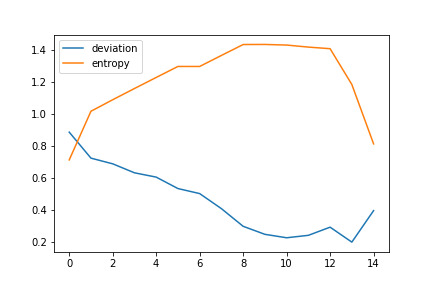

In [222]:
import scipy.stats
mean = [np.mean(x) for x in dWs] 
var = [np.var(x)*10 for x in dWs]
entropy = [scipy.stats.entropy(x)/10 for x in dWs]
deviation = np.array(cosine[-1])

fig, ax = plt.subplots()

# ax.plot(layers, mean, label='mean')
# ax.plot(layers, var, label='variance')
ax.plot(layers, deviation, label='deviation')
ax.plot(layers, entropy, label='entropy')
ax.legend(loc='best')

plt.show()

<IPython.core.display.Javascript object>


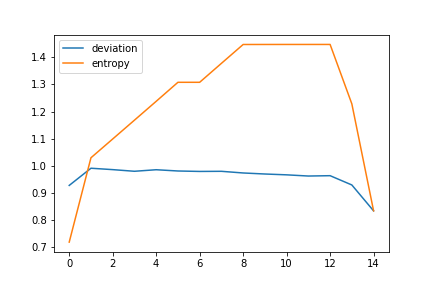

In [224]:
import scipy.stats
mean = [np.mean(x) for x in dWs] 
var = [np.var(x)*10 for x in dWs]
entropy = [scipy.stats.entropy(x)/10 for x in dWs]
deviation = np.array(cosine[-1])

fig, ax = plt.subplots()

# ax.plot(layers, mean, label='mean')
# ax.plot(layers, var, label='variance')
ax.plot(layers, deviation, label='deviation')
ax.plot(layers, entropy, label='entropy')
ax.legend(loc='best')

plt.show()

<IPython.core.display.Javascript object>


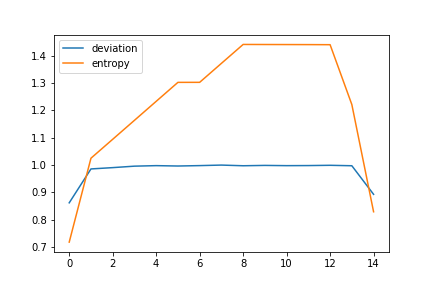

In [226]:
import scipy.stats
mean = [np.mean(x) for x in dWs] 
var = [np.var(x)*10 for x in dWs]
entropy = [scipy.stats.entropy(x)/10 for x in dWs]
deviation = np.array(cosine[-1])

fig, ax = plt.subplots()

# ax.plot(layers, mean, label='mean')
# ax.plot(layers, var, label='variance')
ax.plot(layers, deviation, label='deviation')
ax.plot(layers, entropy, label='entropy')
ax.legend(loc='best')

plt.show()

In [10]:
for name, model in models:
    pathlib.Path(figures_path(name) + 'final').mkdir(parents=True, exist_ok=True)